# LCvx: 3-DoF Fuel-Optimal Rocket Landing

*In this example, we apply the theory of <u>lossless convexification</u> to compute a minimum fuel trajectory for rocket landing on Mars. Similar methods have been applied to sub-orbital and orbital rocket landing [1], [2].*

[1] D. P. Scharf, B. Açıkmeşe, D. Dueri, J. Benito, and J. Casoliva, "Implementation and experimental demonstration of onboard powered-descent guidance," Journal of Guidance, Control, and Dynamics, vol. 40, pp. 213-229, Feb. 2017.

[2] L. Blackmore, "Autonomous precision landing of space rockets," The Bridge, vol. 4, pp. 15–20, Dec. 2016.

Begin by importing appropriate Julia packages. We'll use [ECOS](https://github.com/embotech/ecos) as our SOCP back-end solver, and [JuMP](https://github.com/jump-dev/JuMP.jl) as the optimization problem front-end parser.

In [491]:
using LinearAlgebra
using JuMP, ECOS
using Printf
using PyPlot

## Data structures

This section defines data structures that we'll use for implementing the rocket landing problem.

First, define some variable type aliases.

In [492]:
global const LCvxReal = Float64
global const LCvxVector = Vector{LCvxReal}
global const LCvxMatrix = Matrix{LCvxReal}
;

Define the rocket object data type.

In [493]:
mutable struct Rocket
    g::LCvxVector     # [m/s²] Acceleration due to gravity
    ω::LCvxVector     # [rad/s] Planet angular velocity
    m_dry::LCvxReal   # [kg] Dry mass (structure)
    m_wet::LCvxReal   # [kg] Wet mass (structure+fuel)
    Isp::LCvxReal     # [s] Specific impulse
    ϕ::LCvxReal       # [rad] Rocket engine cant angle
    α::LCvxReal       # [s/m] 1/(rocket engine exit velocity)
    ρ_min::LCvxReal   # [N] Minimum thrust
    ρ_max::LCvxReal   # [N] Maximum thrust
    γ_gs::LCvxReal    # [rad] Maximum approach angle
    γ_p::LCvxReal     # [rad] Maximum pointing angle
    v_max::LCvxReal   # [m/s] Maximum velocity
    r0::LCvxVector    # [m] Initial position
    v0::LCvxVector    # [m] Initial velocity
    Δt::LCvxReal      # [s] Discretization time step
    A_c::LCvxMatrix   # Continuous-time dynamics A matrix
    B_c::LCvxMatrix   # Continuous-time dynamics B matrix
    p_c::LCvxVector   # Continuous-time dynamics p vector
    n::Int            # Number of states
    m::Int            # Number of inputs
end

The next function creates a rocket object with the appropriate 3-DoF dynamics, given user-defined problem parameters.

In [494]:
function Rocket(g::LCvxVector,ω::LCvxVector,m_dry::LCvxReal,
                m_wet::LCvxReal,Isp::LCvxReal,ϕ::LCvxReal,ρ_min::LCvxReal,
                ρ_max::LCvxReal,γ_gs::LCvxReal,γ_p::LCvxReal,
                v_max::LCvxReal,r0::LCvxVector,v0::LCvxVector,
                Δt::LCvxReal)::Rocket
    # Initialize rocket object with the appropriate parameters.
    #
    # :in *: see corresponding term in Rocket struct.
    # :out rocket: the rocket object.

    # ..:: Continuous-time dynamics ::..
    ge = 9.807 # Standard gravity
    α = 1/(Isp*ge*cos(ϕ))
    ω_x = LCvxMatrix([0 -ω[3] ω[2];ω[3] 0 -ω[1];-ω[2] ω[1] 0])
    A_c = LCvxMatrix([zeros(3,3) I(3) zeros(3);
                      -(ω_x)^2 -2*ω_x zeros(3);
                      zeros(1,7)])
    B_c = LCvxMatrix([zeros(3,4);
                      I(3) zeros(3,1);
                      zeros(1,3) -α])
    p_c = LCvxVector(vcat(zeros(3),g,0))
    n,m = size(B_c)

    # ..:: Make rocket object ::..
    rocket = Rocket(g,ω,m_dry,m_wet,Isp,ϕ,α,ρ_min,ρ_max,γ_gs,γ_p,v_max,
                    r0,v0,Δt,A_c,B_c,p_c,n,m)

    return rocket
end
;

Define the solution object data type.

In [495]:
struct Solution
    # >> Raw data <<
    t::LCvxVector      # [s] Time vector
    r::LCvxMatrix      # [m] Position trajectory
    v::LCvxMatrix      # [m/s] Velocity trajectory
    z::LCvxVector      # [log(kg)] Log(mass) history
    u::LCvxMatrix      # [m/s^2] Acceleration vector
    ξ::LCvxVector      # [m/s^2] Acceleration magnitude
    
    # >> Processed data <<
    cost::LCvxReal     # Optimization's optimal cost
    T::LCvxMatrix      # [N] Thrust trajectory
    T_nrm::LCvxVector  # [N] Thrust norm trajectory
    m::LCvxVector      # [kg] Mass history
    γ::LCvxVector      # [rad] Pointing angle
end

The next function creates an "infeasible" solution object.

In [496]:
function FailedSolution()::Solution
    # Create an infeasible solution.
    #
    # :out : infeasible solution
    t = LCvxVector(undef,0)
    r = LCvxMatrix(undef,0,0)
    v = LCvxMatrix(undef,0,0)
    z = LCvxVector(undef,0)
    u = LCvxMatrix(undef,0,0)
    ξ = LCvxVector(undef,0)
    cost = Inf
    T = LCvxMatrix(undef,0,0)
    T_nrm = LCvxVector(undef,0)
    m = LCvxVector(undef,0)
    γ = LCvxVector(undef,0)
    return Solution(t,r,v,z,u,ξ,cost,T,T_nrm,m,γ)
end
;

Let's now instantiate a rocket that we'll be landing!

In [533]:
e_x = LCvxVector([1,0,0])
e_y = LCvxVector([0,1,0])
e_z = LCvxVector([0,0,1])
g = -3.7114*e_z
θ = 30*π/180                                           # [rad] Latitude of landing site
T_sidereal_mars = 24.6229*3600 # [s]
ω = (2π/T_sidereal_mars)*(e_x*cos(θ)+e_y*0+e_z*sin(θ))
m_dry = 1505.0
m_wet = 1905.0
Isp = 225.0
n_eng = 6                                              # Number of engines
ϕ = 27*π/180                                           # [rad] Engine cant angle off vertical
T_max = 3.1e3                                          # [N] Max physical thrust of single engine
T_1 = 0.3*T_max                                        # [N] Min allowed thrust of single engine
T_2 = 0.8*T_max                                        # [N] Max allowed thrust of single engine
ρ_min = n_eng*T_1*cos(ϕ)
ρ_max = n_eng*T_2*cos(ϕ)
γ_gs = 86*π/180
γ_p = 40*π/180
v_max = 500*1e3/3600
r0 = (2*e_x+0*e_y+1.5*e_z)*1e3
v0 = 80*e_x+30*e_y-75*e_z
Δt = 1e0

rocket = Rocket(g,ω,m_dry,m_wet,Isp,ϕ,ρ_min,ρ_max,γ_gs,γ_p,v_max,r0,v0,Δt);

## Helper functions

This section defines "utility" functions that we'll make use of in the implementation of lossless convexification. You can think of them as lower-level "tools" that get used as part of solving the rocket landing problem.

The next function disretizes continuous-time dynamics using zeroth-order hold on the input signal.

In [498]:
function c2d(rocket::Rocket, Δt::LCvxReal)::Tuple{LCvxMatrix, LCvxMatrix, LCvxVector}
    # Discretize rocket dynamics at Δt time step using zeroth-order
    # hold (ZOH). This updates the {A,B,p} parameters of the rocket
    # object.
    #
    # :in rocket: the rocket object.
    # :in Δt: the discretization time step.
    # :out : a tuple (A,B,p) for the discrete-time update equation
    #         x_{k+1} = A*x_k+B*u_k+p
    A_c,B_c,p_c,n,m = rocket.A_c,rocket.B_c,rocket.p_c,rocket.n,rocket.m
    _M = exp(LCvxMatrix([A_c B_c p_c;zeros(m+1,n+m+1)])*Δt)
    A = _M[1:n,1:n]
    B = _M[1:n,n+1:n+m]
    p = _M[1:n,n+m+1]
    return (A,B,p)
end
;

The next function applies the golden search method to minimize a real unimodal function $f:\mathbb R\to\mathbb R$ over the domain $[a,b]$.

In [499]:
function golden(f::Function, a::LCvxReal, b::LCvxReal, tol::LCvxReal)::Tuple{LCvxReal, LCvxReal}
    # Golden search for minimizing a unimodal function f(x) on the
    # interval [a,b] to within a prescribed golerance in
    # x. Implementation is based on [1].
    #
    # [1] M. J. Kochenderfer and T. A. Wheeler, Algorithms for
    # Optimization. Cambridge, Massachusetts: The MIT Press, 2019.
    #
    # :in f: oracle with call signature v=f(x) where v is saught to be
    #        minimized.
    # :in a: search domain lower bound.
    # :in b: search domain upper bound.
    # :in tol: tolerance in terms of maximum distance that the
    #          minimizer x∈[a,b] is away from a or b.
    # :out sol: a tuple where s[1] is the argmin and s[2] is the argmax.
    ϕ = (1+√5)/2
    n = ceil(log((b-a)/tol)/log(ϕ)+1)
    ρ = ϕ-1
    d = ρ*b+(1-ρ)*a
    yd = f(d)
    for i = 1:n-1
        c = ρ*a+(1-ρ)*b
        yc = f(c)
        if yc<yd
            b,d,yd = d,c,yc
        else
            a,b = b,c
        end
        bracket = sort([a,b,c,d])
        @printf("golden bracket: [%3.f,%.3f,%.3f,%.3f]\n", bracket...)
    end
    x_sol = b
    sol = (x_sol,f(x_sol))
    return sol
end
;

The next function integrates a time-varying system of ordinary differential equations $\dot x(t)=f(t,x(t))$, where $f:\mathbb R\times\mathbb R^n\to\mathbb R^n$, over the time interval $[0,T]$ starting from an initial condition $x(0)=x_0$. The numerical integration method is [Runge-Kutta 4](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#The_Runge%E2%80%93Kutta_method), and the integration time step is a specified $\Delta t\in\mathbb R_{++}$.

In [500]:
function rk4(f::Function, x0::LCvxVector, Δt::LCvxReal, T::LCvxReal)::Tuple{LCvxVector, LCvxMatrix}
    # Integrate a system of ordinary differential equations (ODE)
    # using RK4.
    #
    # :in f: the function defining the ODE, dx/dt=f(t,x).
    # :in x0: the initial condition.
    # :in Δt: the integration time step.
    # :in T: the integration final time.
    # :out : a vector storing the integration times.
    # :out : a matrix storing in its columns the integrated state
    #        trajectory.

    # ..:: Make time grid ::..
    t = LCvxVector(0.0:Δt:T)
    if (T-t[end])>=√eps()
        push!(t,T)
    end
    N = length(t)

    # ..:: Initialize ::..
    X = LCvxMatrix(undef,length(x0),N)
    X[:,1] = x0

    # ..:: Integrate ::..
    for n = 1:N-1
        y = X[:,n]
        h = t[n+1]-t[n]
        t_ = t[n]
        k1 = f(t_,y)
        k2 = f(t_+h/2,y+h*k1/2)
        k3 = f(t_+h/2,y+h*k2/2)
        k4 = f(t_+h,y+h*k3)
        X[:,n+1] = y+h/6*(k1+2*k2+2*k3+k4)
    end

    return (t,X)
end
;

The next function performs a numerical simulation of the rocket dynamics under a given control law, provided as a callable function.

In [501]:
function simulate(rocket::Rocket, control::Function, t_f::LCvxReal)::Solution
    # Integrate the rocket dynamics using a predefined control input
    # trajectory.
    #
    # :in rocket: the rocket object.
    # :in control: the control trajectory, expressed as a function
    #              u=control(t,x,r) where u is the control input, t
    #              is the time, x is the state, and r is the rocket
    #              object.
    # :in t_f: the time of flight.
    # :out sim: the simulation output as a Solution object.

    # ..:: Simulate ::..

    dynamics = (t,x) -> rocket.A_c*x+rocket.B_c*control(t,x,rocket)+rocket.p_c
    x0 = LCvxVector(vcat(rocket.r0,rocket.v0,log(rocket.m_wet)))
    Δt = 1e-2
    t,X = rk4(dynamics,x0,Δt,t_f)
    U = LCvxMatrix(hcat([control(t[n],X[:,n],rocket) for n = 1:length(t)]...))
    N = length(t)

    # ..:: Save solution ::..

    r = X[1:3,:]
    v = X[4:6,:]
    z = X[7,:]
    u = U[1:3,:]
    ξ = U[4,:]

    m = exp.(z)
    T = LCvxMatrix(transpose(hcat([m.*u[i,:] for i=1:3]...)))
    T_nrm = LCvxVector([norm(T[:,i],2) for i=1:N])
    γ = LCvxVector([acos(dot(T[:,k],e_z)/norm(T[:,k],2)) for k=1:N])

    sim = Solution(t,r,v,z,u,ξ,0.0,T,T_nrm,m,γ)

    return sim
end
;

## Solve via Lossless Convexification

This section finds the optimal rocket landing trajectory by solving the relaxed convex problem (via lossless convexification theory).

The next function solves the rocket landing problem for a fixed time of flight.

In [502]:
function solve_pdg_fft(rocket::Rocket,t_f::LCvxReal)::Solution
    # Solve the rocket landing problem for a fixed time of flight.
    #
    # :in rocket: the rocket object.
    # :in t_f: the time of flight.
    # :out sol: solution to the rocket landing problem for this t_f.

    # ..:: Discretize [0,t_f] interval ::..

    # If t_f does not divide into rocket.Δt intervals evenly, then reduce Δt by
    # minimum amount to get an integer number of intervals
    N = Int(floor(t_f/rocket.Δt))+1+Int(t_f%rocket.Δt!=0) # Number of time nodes
    Δt = t_f/(N-1)
    t = LCvxVector(0.0:Δt:t_f)

    A,B,p = c2d(rocket,Δt)

    # ..:: Make the optimization problem ::..
    mdl = Model(with_optimizer(ECOS.Optimizer,verbose=0))

    # >> (Scaled) variables <<
    @variable(mdl, r_s[1:3,1:N])
    @variable(mdl, v_s[1:3,1:N])
    @variable(mdl, z_s[1:N])
    @variable(mdl, u_s[1:3,1:N-1])
    @variable(mdl, ξ_s[1:N-1])

    # >> Scaling (for better numerical behaviour) <<

    # @ Scaling matrices @
    s_r = zeros(3)
    S_r = Diagonal([max(1.0,abs(rocket.r0[i])) for i=1:3])
    s_v = zeros(3)
    S_v = Diagonal([max(1.0,abs(rocket.v0[i])) for i=1:3])
    s_z = (log(rocket.m_dry)+log(rocket.m_wet))/2
    S_z = log(rocket.m_wet)-s_z
    s_u = LCvxVector([0,0,0.5*(rocket.ρ_min/rocket.m_wet*cos(rocket.γ_p)+
                               rocket.ρ_max/rocket.m_dry)])
    S_u = Diagonal([rocket.ρ_max/rocket.m_dry*sin(rocket.γ_p),
                    rocket.ρ_max/rocket.m_dry*sin(rocket.γ_p),
                    rocket.ρ_max/rocket.m_dry-s_u[3]])
    s_ξ,S_ξ = s_u[3],S_u[3,3]

    # @ Unscaled variables @
    r = S_r*r_s+repeat(s_r,1,N)
    v = S_v*v_s+repeat(s_v,1,N)
    z = S_z*z_s+repeat([s_z],N)
    u = S_u*u_s+repeat(s_u,1,N-1)
    ξ = S_ξ*ξ_s+repeat([s_ξ],N-1)

    # >> Cost function <<
    @objective(mdl, Min, Δt*sum(ξ))

    # >> Constraints <<

    # @ Dynamics @
    X = (k) -> [r[:,k];v[:,k];z[k]] # State at time index k
    U = (k) -> [u[:,k];ξ[k]] # Input at time index k
    @constraint(mdl, [k=1:N-1], X(k+1).==A*X(k)+B*U(k)+p)

    # @ Thrust bounds (approximate) @
    z0 = (k) -> log(rocket.m_wet-rocket.α*rocket.ρ_max*t[k])
    μ_min = (k) -> rocket.ρ_min*exp(-z0(k))
    μ_max = (k) -> rocket.ρ_max*exp(-z0(k))
    δz = (k) -> z[k]-z0(k)
    @constraint(mdl, [k=1:N-1], ξ[k]>=μ_min(k)*(1-δz(k)+0.5*δz(k)^2))
    @constraint(mdl, [k=1:N-1], ξ[k]<=μ_max(k)*(1-δz(k)))

    # @ Mass physical bounds constraint @
    @constraint(mdl, [k=1:N], z0(k)<=z[k])
    @constraint(mdl, [k=1:N], z[k]<=log(rocket.m_wet-rocket.α*rocket.ρ_min*t[k]))

    # @ Thrust bounds LCvx @
    @constraint(mdl, [k=1:N-1], vcat(ξ[k],u[:,k]) in
                MOI.SecondOrderCone(4))

    # @ Attitude pointing constraint @
    e_z = LCvxVector([0,0,1])
    @constraint(mdl, [k=1:N-1], dot(u[:,k],e_z)>=ξ[k]*cos(rocket.γ_p))

    # @ Glide slope constraint @
    H_gs = LCvxMatrix([cos(rocket.γ_gs) 0 -sin(rocket.γ_gs);
                       -cos(rocket.γ_gs) 0 -sin(rocket.γ_gs);
                       0 cos(rocket.γ_gs) -sin(rocket.γ_gs);
                       0 -cos(rocket.γ_gs) -sin(rocket.γ_gs)])
    h_gs = zeros(4)
    @constraint(mdl, [k=1:N], H_gs*r[:,k].<=h_gs)

    # @ Velocity upper bound @
    @constraint(mdl, [k=1:N], vcat(rocket.v_max,v[:,k]) in
                MOI.SecondOrderCone(4))

    # @ Boundary conditions @
    @constraint(mdl, r[:,1].==rocket.r0)
    @constraint(mdl, v[:,1].==rocket.v0)
    @constraint(mdl, z[1]==log(rocket.m_wet))
    @constraint(mdl, r[:,N].==zeros(3))
    @constraint(mdl, v[:,N].==zeros(3))
    @constraint(mdl, z[N]>=log(rocket.m_dry))

    # >> Solve problem <<
    optimize!(mdl)
    if termination_status(mdl)!=MOI.OPTIMAL
        return FailedSolution()
    end

    # ..:: Save the solution ::..

    r = value.(r)
    v = value.(v)
    z = value.(z)
    u = value.(u)
    ξ = value.(ξ)

    cost = objective_value(mdl)
    m = exp.(z)
    T = LCvxMatrix(transpose(hcat([m[1:end-1].*u[i,:] for i=1:3]...)))
    T_nrm = LCvxVector([norm(T[:,i],2) for i=1:N-1])
    γ = LCvxVector([acos(dot(T[:,k],e_z)/norm(T[:,k],2)) for k=1:N-1])

    sol = Solution(t,r,v,z,u,ξ,cost,T,T_nrm,m,γ)

    return sol
end
;

We now use the above function inside of a golden search routine, to find the minimum fuel time of flight.

In [503]:
tol = 1e-3 # Suboptimality tolerance for golden search

# The minimum time of flight is given by the time taken to
# zero the velocity at the lightest weight (after that, the
# rocket can no longer reduce altitude, so will never touch down
# unless it has done so already). Ignoring gravity gives a lower bound.
tf_min = rocket.m_dry*norm(rocket.v0,2)/rocket.ρ_max

# The maximum time of flight is given by the time taken to
# deplete fuel at minimum thrust
tf_max = (rocket.m_wet-rocket.m_dry)/(rocket.α*rocket.ρ_min)

t_opt,cost_opt = golden((t_f) -> solve_pdg_fft(rocket,t_f).cost, tf_min, tf_max, tol)

pdg = solve_pdg_fft(rocket,t_opt); # Optimal 3-DoF PDG trajectory

golden bracket: [68.394309,68.394,102.688,158.177]
golden bracket: [68.394309,102.688,123.883,123.883]
golden bracket: [68.394309,89.589,89.589,102.688]
golden bracket: [68.394309,81.493,81.493,89.589]
golden bracket: [68.394309,76.490,76.490,81.493]
golden bracket: [73.397751,73.398,76.490,81.493]
golden bracket: [73.397751,76.490,78.401,78.401]
golden bracket: [73.397751,75.309,75.309,76.490]
golden bracket: [74.578903,74.579,75.309,76.490]
golden bracket: [74.578903,75.309,75.760,75.760]
golden bracket: [74.578903,75.030,75.030,75.309]
golden bracket: [74.857735,74.858,75.030,75.309]
golden bracket: [74.857735,75.030,75.137,75.137]
golden bracket: [74.964239,74.964,75.030,75.137]
golden bracket: [74.964239,75.030,75.071,75.071]
golden bracket: [74.964239,75.005,75.005,75.030]
golden bracket: [74.964239,74.989,74.989,75.005]
golden bracket: [74.979778,74.980,74.989,75.005]
golden bracket: [74.989382,74.995,74.995,75.005]
golden bracket: [74.995317,74.999,74.999,75.005]
golden bracket

Now let's run the optimal control through a numerical integrator, to get a "continuous time" trajectory. If all went well, this should exactly match the optimization output at the discrete time points.

First, define a function which maps the optimal solution in the transformed variables of lossless convexification, back to the original variables of the rocket landing problem.

In [504]:
function optimal_controller(t::LCvxReal, x::LCvxVector, rocket::Rocket, sol::Solution)::LCvxVector
    # Output the optimal control input (rocket engine thrust vector) at time t.
    #
    # :in t: the time at which to compute the optimal control.
    # :in x: the current state.
    # :in rocket: the rocket object.
    # :in sol: the optimized solution.
    # :out u: the optimal input for the state-space form of the rocket
    #         dynamics.

    # Get current mass
    z = x[7]
    m = exp.(z)

    # Get current optimal acceleration (ZOH interpolation)
    i = findlast(τ->τ<=t,sol.t)
    if typeof(i)==Nothing || i>=size(sol.u,2)
        u = sol.u[:,end]
    else
        u = sol.u[:,i]
    end

    # Get current optimal thrust
    T = u*m

    # Create the input vector for the state-space dynamics
    u = LCvxVector(vcat(T/m,norm(T,2)/m))

    return u
end
;

We can now perform the numerical simulation.

In [505]:
optimal_control = (t,x,rocket) -> optimal_controller(t,x,rocket,pdg)
sim = simulate(rocket,optimal_control,pdg.t[end]);

## Result plots

This section plots the computed optimal trajectory. You can find a discussion of the results in the CSM paper.

Define convenient variables for easier plotting code.

In [506]:
v_max = rocket.v_max*3.6

t = pdg.t
N = length(t)
r_x = pdg.r[1,:]*1e-3
r_y = pdg.r[2,:]*1e-3
r_z = pdg.r[3,:]*1e-3
v_x = pdg.v[1,:]*3.6
v_y = pdg.v[2,:]*3.6
v_z = pdg.v[3,:]*3.6
mass = pdg.m
T = pdg.T*1e-3

t_sim = sim.t
N_sim = length(t_sim)
r_x_sim = sim.r[1,:]*1e-3
r_y_sim = sim.r[2,:]*1e-3
r_z_sim = sim.r[3,:]*1e-3
v_x_sim = sim.v[1,:]*3.6
v_y_sim = sim.v[2,:]*3.6
v_z_sim = sim.v[3,:]*3.6
mass_sim = sim.m
T_sim = sim.T*1e-3

;

Define plot styles.

In [507]:
style_ct = Dict(:color=>"black",:linewidth=>1.5)
style_dt = Dict(:color=>"orange",:linestyle=>"none",:marker=>".",:markersize=>4)
style_thrust = Dict(:edgecolor=>"none",:facecolor=>"red",:width=>0.005,:head_width=>0.03,:alpha=>0.3)
style_hover = Dict(:color=>"blue",:linewidth=>1.5)
style_apch_cone = Dict(:color=>"blue",:linewidth=>1, :linestyle=>"dashed")
style_ground = Dict(:facecolor=>"brown",:edgecolor=>"none",:alpha=>0.3)
style_constraint = Dict(:color=>"red",:linestyle=>"--",:linewidth=>2)
style_constraint_fill = Dict(:edgecolor=>"none",:facecolor=>"black",:alpha=>0.1)
;

### Convenience functions

This section defines some utility functions for plotting.

In [508]:
function get_thrust_vec(pdg::Solution,k::Int,i::Int,j::Int,scale::LCvxReal=0.4)::LCvxVector
    # Compute a thrust vector "arrow".
    #
    # :in pdg: the optimized solution.
    # :in k: the discrete time step for which to plot.
    # :in i: the "x" axis.
    # :in j: the "y" axis.
    # :in scale: multiplicative scaling factor to apply to the thrust
    #            vector.
    T = pdg.T[:,k]/ρ_max*scale
    r = pdg.r[:,k]*1e-3
    return [r[i],r[j],T[i],T[j]]
end
;

In [509]:
function set_fonts()::Nothing
    # Set the figure fonts.
    fig_small_sz = 12
    fig_med_sz = 15
    fig_big_sz = 17
    plt.rc("text", usetex=true)
    plt.rc("font", size=fig_small_sz, family="serif")
    plt.rc("axes", titlesize=fig_small_sz)
    plt.rc("axes", labelsize=fig_med_sz)
    plt.rc("xtick", labelsize=fig_small_sz)
    plt.rc("ytick", labelsize=fig_small_sz)
    plt.rc("legend", fontsize=fig_small_sz)
    plt.rc("figure", titlesize=fig_big_sz)
    
    return nothing
end
;

In [510]:
function draw_approach(ax; ground_h::Float64 = -0.1, apch_cone_w::Float64 = 10.0)::Nothing
    # Draw the approach cone for the rocket landing problem (in 2D).
    #
    # :in ax: the graph axes object on which to draw the approach cone
    # :in ground_h: the below-ground vertical space to show
    # :in apch_cone_w: width of the approach cone

    # Adjust below-ground level
    ylim = ax.get_ylim()
    dz = ground_h-ylim[1]
    ylim = ylim.+dz
    ax.set_ylim(ylim)
    xlim,ylim = ax.get_xlim(),ax.get_ylim()

    # Draw the approach cone
    apch_cone_x = [-apch_cone_w,0,apch_cone_w]
    apch_cone_y = abs.(apch_cone_x)./tan(rocket.γ_gs)
    ax.plot(apch_cone_x,apch_cone_y; style_apch_cone...)

    # Draw the ground
    ax.fill_between([-apch_cone_w,apch_cone_w],ground_h,0; style_ground...)

    # Adjust axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return nothing
end
;

### Position trajectory plot

In [511]:
# Find regions of max and min thrust
T_nrm = LCvxVector([norm(T[:,i]) for i=1:N-1])
max_thrust = Array{Bool,1}([(ρ_max-norm(T[:,i])*1e3)/ρ_max<1e-2 for i=1:N-1])
append!(max_thrust, max_thrust[end])
min_thrust = .!max_thrust
;

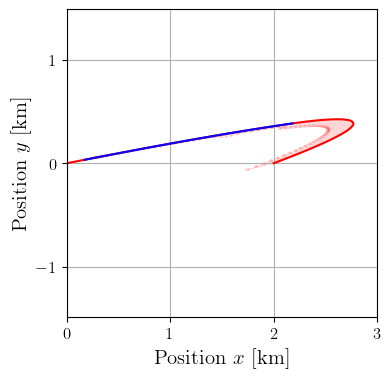

In [512]:
fig = plt.figure(figsize=(4,4))
plt.clf()
set_fonts()

ax = fig.add_subplot()
ax.axis("equal")
ax.grid()
ax.set_facecolor("white")
fig.patch.set_alpha(0)

# Max-thrust regime
ax.plot(r_x,r_y; style_ct..., color="red")

# Min-thrust regime
tmp_x = copy(r_x)
tmp_y = copy(r_y)
tmp_x[max_thrust] .= Inf
tmp_y[max_thrust] .= Inf
ax.plot(tmp_x,tmp_y; style_ct..., color="blue")

for k = 1:N-1
    ax.arrow(get_thrust_vec(pdg,k,1,2)...; style_thrust...)
end

ax.set_xlabel(L"Position $x$ [km]")
ax.set_ylabel(L"Position $y$ [km]")

ax.set_xticks(ticks=[0,1,2,3])
ax.set_yticks(ticks=[-1,0,1])

ax.set_xlim([0,3])
ax.set_ylim([-1,1])

fig.savefig("figures/lcvx_3dof_rocket_pos_xy.pdf",bbox_inches="tight")
;

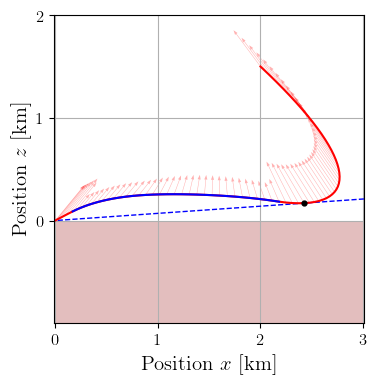

In [513]:
fig = plt.figure(figsize=(4,4))
plt.clf()
set_fonts()

ax = fig.add_subplot()
ax.axis("equal")
ax.grid()
ax.set_facecolor("white")
fig.patch.set_alpha(0)

draw_approach(ax; ground_h=-2.0)

# Max-thrust regime
ax.plot(r_x,r_z; style_ct..., color="red")

# Min-thrust regime
tmp_x = copy(r_x)
tmp_z = copy(r_z)
tmp_x[max_thrust] .= Inf
tmp_z[max_thrust] .= Inf
ax.plot(tmp_x,tmp_z; style_ct..., color="blue")

for k = 1:N-1
    ax.arrow(get_thrust_vec(pdg,k,1,3)...; style_thrust...)
end

# Put markers where the slideslope constraint activates
n = [cos(rocket.γ_gs);0;-sin(rocket.γ_gs)] # Glide slope normal
for i = 1:N
    local gs_dot = -dot(n,[r_x[i];r_y[i];r_z[i]])
    if gs_dot<1e-12 && r_z[i]>1e-10
        ax.plot(r_x[i],r_z[i]; color="black",marker=".",markersize=7)
    end
end

ax.set_xlabel(L"Position $x$ [km]")
ax.set_ylabel(L"Position $z$ [km]")

ax.set_xticks(ticks=[0,1,2,3])
ax.set_yticks(ticks=[0,1,2])

ax.set_ylim([-1,2])
ax.set_xlim([0,3])


fig.savefig("figures/lcvx_3dof_rocket_pos_xz.pdf",bbox_inches="tight")
;

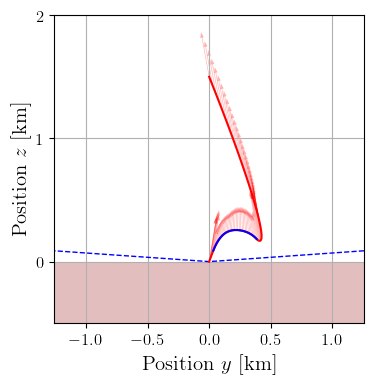

In [514]:
fig = plt.figure(figsize=(4,4))
plt.clf()
set_fonts()

ax = fig.add_subplot()
ax.axis("equal")
ax.grid()
ax.set_facecolor("white")
fig.patch.set_alpha(0)

draw_approach(ax; ground_h=-2.0)

# Max-thrust regime
ax.plot(r_y,r_z; style_ct..., color="red")

# Min-thrust regime
tmp_y = copy(r_y)
tmp_z = copy(r_z)
tmp_y[max_thrust] .= Inf
tmp_z[max_thrust] .= Inf
ax.plot(tmp_y,tmp_z; style_ct..., color="blue")

for k = 1:N-1
    ax.arrow(get_thrust_vec(pdg,k,2,3)...; style_thrust...)
end

ax.set_xlabel(L"Position $y$ [km]")
ax.set_ylabel(L"Position $z$ [km]")

ax.set_xticks(ticks=[-1,-0.5,0,0.5,1])
ax.set_yticks(ticks=[0,1,2])

ax.set_xlim([-1,1])
ax.set_ylim([-0.5,2])

fig.savefig("figures/lcvx_3dof_rocket_pos_yz.pdf",bbox_inches="tight")
;

### Speed plot

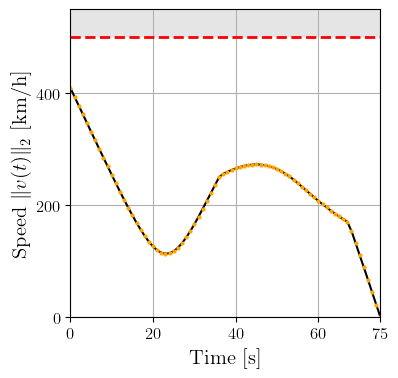

In [515]:
fig = plt.figure(figsize=(4,4))
plt.clf()
set_fonts()

ax = fig.add_subplot()
ax.grid()
ax.set_facecolor("white")
fig.patch.set_alpha(0)

v_nrm = LCvxVector([norm([v_x[i];v_y[i];v_z[i]]) for i=1:N])
v_sim_nrm = LCvxVector([norm([v_x_sim[i];v_y_sim[i];v_z_sim[i]]) for i=1:N_sim])

ax.axhline(y=v_max; style_constraint...)
ax.fill_between([0,t_opt],v_max,v_max+50; style_constraint_fill...)
ax.plot(t_sim, v_sim_nrm; style_ct...)
ax.plot(t, v_nrm; style_dt...)

ax.set_xticks(ticks=[0,20,40,60,75])
ax.set_yticks(ticks=[0,200,400,600,800,850])

ax.set_xlim([0,75])
ax.set_ylim([0,v_max+50])

ax.set_xlabel("Time [s]")
ax.set_ylabel(L"Speed $\|v(t)\|_2$ [km/h]")

fig.savefig("figures/lcvx_3dof_rocket_speed.pdf",bbox_inches="tight")
;

### Mass plot

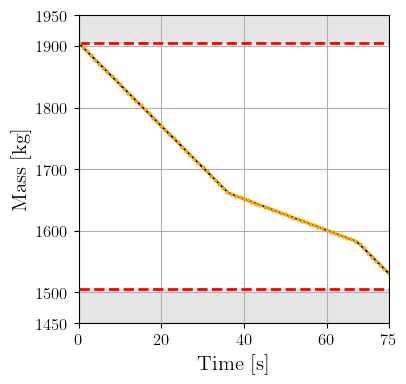

In [516]:
fig = plt.figure(4,figsize=(4,4))
plt.clf()
set_fonts()

ax = fig.add_subplot()
ax.grid()
ax.set_facecolor("white")
fig.patch.set_alpha(0)

ax.axhline(y=rocket.m_dry; style_constraint...)
ax.fill_between([0,t_opt],rocket.m_dry,rocket.m_dry-100; style_constraint_fill...)
ax.axhline(y=rocket.m_wet; style_constraint...)
ax.fill_between([0,t_opt],rocket.m_wet,rocket.m_wet+100; style_constraint_fill...)
ax.plot(t_sim, mass_sim; style_ct...)
ax.plot(t, mass; style_dt...)

ax.set_xticks(ticks=[0,20,40,60,75])
ax.set_yticks(ticks=[1450,1500,1600,1700,1800,1900,1950])

ax.set_xlim([0,75])
ax.set_ylim([1450,1950])

ax.set_xlabel("Time [s]")
ax.set_ylabel("Mass [kg]")

fig.savefig("figures/lcvx_3dof_rocket_mass.pdf",bbox_inches="tight")
;

### Thrust magnitude plots

The first plot just shows the total thrust vector magnitude. The "lossless convexification" is most apparent during the minimum-thrust time interval. Here, it is feasible for the thrust magnitude to dip below the minimum for relaxed convex problem, but lossless convexification has provided the guarantee that an optimal solution will not do so.

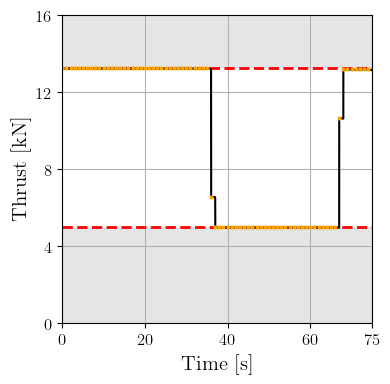

In [517]:
fig = plt.figure(4,figsize=(4,4))
plt.clf()
set_fonts()

ax = fig.add_subplot()
ax.grid()
ax.set_facecolor("white")
fig.patch.set_alpha(0)

T_nrm = LCvxVector([norm(T[:,i]) for i=1:N-1])
T_sim_nrm = LCvxVector([norm(T_sim[:,i]) for i=1:N_sim])

ax.axhline(y=rocket.ρ_min*1e-3; style_constraint...)
ax.fill_between([0,t_opt],rocket.ρ_min*1e-3,0; style_constraint_fill...)
ax.axhline(y=rocket.ρ_max*1e-3; style_constraint...)
ax.fill_between([0,t_opt],rocket.ρ_max*1e-3,rocket.ρ_max*1e-3+16; style_constraint_fill...)
ax.plot(t_sim, T_sim_nrm; style_ct...)
ax.plot(t[1:end-1], T_nrm; style_dt...)

ax.set_xticks(ticks=[0,20,40,60,75])
ax.set_yticks(ticks=[0,4,8,12,16])

ax.set_xlim([0,75])
ax.set_ylim([0,16])

ax.set_xlabel("Time [s]")
ax.set_ylabel("Thrust [kN]")

fig.savefig("figures/lcvx_3dof_rocket_thrust.pdf",bbox_inches="tight")
;

The next plot shows the $z$-component of the thrust, together with a blue "hover line". Above this line, the vehicle is accelerating up (towards the sky), while below this line it is accelerating down (towards the ground).

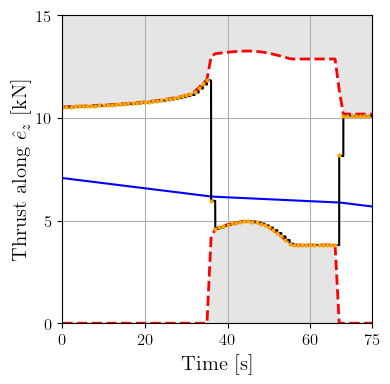

In [518]:
fig = plt.figure(2,figsize=(4,4))
plt.clf()
set_fonts()

ax = fig.add_subplot()
ax.grid()
ax.set_facecolor("white")
fig.patch.set_alpha(0)

T_z = LCvxVector([T[3,i] for i=1:N-1])
T_z_sim = LCvxVector([T_sim[3,i] for i=1:N_sim])
T_z_max = LCvxVector([sqrt((ρ_max*1e-3)^2-T[1,i]^2-T[2,i]^2) for i=1:N-1])
append!(T_z_max, T_z_max[end])
T_z_min = LCvxVector([sqrt(max(0,(ρ_min*1e-3)^2-T[1,i]^2-T[2,i]^2)) for i=1:N-1])
append!(T_z_min, T_z_min[end])
hover_line = mass*norm(g)*1e-3

ax.plot(t, T_z_max; style_constraint...)
ax.fill_between(t,T_z_max,40; style_constraint_fill...)
ax.plot(t, T_z_min; style_constraint...)
ax.fill_between(t,T_z_min,0; style_constraint_fill...)
ax.plot(t, hover_line; style_hover...)
ax.plot(t_sim, T_z_sim; style_ct...)
ax.plot(t[1:end-1], T_z; style_dt...)

ax.set_xticks(ticks=[0,20,40,60,75])
ax.set_yticks(ticks=[0,5,10,15])

ax.set_xlim([0,75])
ax.set_ylim([0,15])

ax.set_xlabel("Time [s]")
ax.set_ylabel(L"Thrust along $\hat e_z$ [kN]")

fig.savefig("figures/lcvx_3dof_rocket_thrust_z.pdf",bbox_inches="tight")
;

### Pointing angle plot

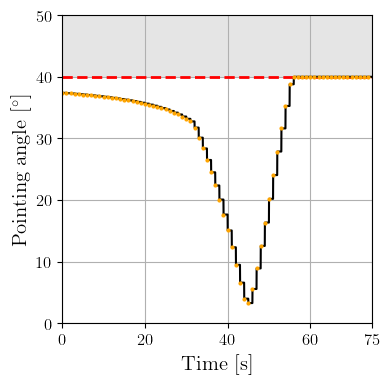

In [519]:
fig = plt.figure(4,figsize=(4,4))
plt.clf()
set_fonts()

ax = fig.add_subplot()
ax.grid()
ax.set_facecolor("white")
fig.patch.set_alpha(0)

pa = LCvxVector([acos(T[3,i]/norm(T[:,i]))*180/pi for i=1:N-1])
pa_sim = LCvxVector([acos(T_sim[3,i]/norm(T_sim[:,i]))*180/pi for i=1:N_sim])

ax.axhline(rocket.γ_p*180/pi; style_constraint...)
ax.fill_between([0,t_opt],rocket.γ_p*180/pi,rocket.γ_p*180/pi+20; style_constraint_fill...)
ax.plot(t_sim, pa_sim; style_ct...)
ax.plot(t[1:end-1], pa; style_dt...)

ax.set_xticks(ticks=[0,20,40,60,75])
ax.set_yticks(ticks=[0,10,20,30,40,50])

ax.set_xlim([0,75])
ax.set_ylim([0,50])

ax.set_xlabel("Time [s]")
ax.set_ylabel(L"Pointing angle [$^\circ$]")

fig.savefig("figures/lcvx_3dof_rocket_angle.pdf",bbox_inches="tight")
;